# Install Spark

In [0]:
# Install latest version of spark. If error, check the latest and replace "spark-2.4.4"
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
import findspark
findspark.init()

In [2]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Part 1. kMeans.
Modify kmeans.py provided

In [0]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [0]:
# Macros.
MAX_ITER = 20
DATA_PATH = "/content/gdrive/My Drive/BigData/q1/data.txt"
C1_PATH = "/content/gdrive/My Drive/BigData/q1/c1.txt"
C2_PATH = "/content/gdrive/My Drive/BigData/q1/c2.txt"
NORM = 2

In [0]:
# Load data (corresponding to the def main())
# Spark settings
conf = SparkConf()
sc = SparkContext(conf=conf)
# Load the data, cache this since we're accessing this each iteration
data = sc.textFile(DATA_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).cache()
# Load the initial centroids c1, split into a list of np arrays
centroids1 = sc.textFile(C1_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).collect()
# Load the initial centroids c2, split into a list of np arrays
centroids2 = sc.textFile(C2_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).collect()

In [0]:
# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid.
    """
    closest_c = min([(i, linalg.norm(p - c, norm))
                    for i, c in enumerate(centroids)],
                    key=operator.itemgetter(1))[0]
    return closest_c

In [0]:
def dist(centroid, p, norm):
    """
    Compute closest centroid for a given point.
    Args:
        centroid (numpy.ndarray): centroid of the cluster p belongs to
        p (numpy.ndarray): input point        
        norm (int): 1 or 2
    Returns:
        float: the distance between centroid and p.
    """
    res = 0
    if norm == 1:
      res = linalg.norm(p - centroid, norm)
    elif norm == 2:
      res = linalg.norm(p - centroid, norm) ** 2
    return res

In [0]:
# K-means clustering
def kmeans(data, centroids, norm=2):
    """
    Conduct k-means clustering given data and centroid.
    This is the basic version of k-means, you might need more
    code to record cluster assignment to plot TSNE, and more
    data structure to record cost.
    Args:
        data (RDD): RDD of points
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        RDD: assignment information of points, a RDD of (centroid, (point, 1))
        list: a list of centroids
        loss: a list of within-cluster cost
    """
    # iterative k-means
    loss = []
    for _ in range(MAX_ITER):
        # Transform each point to a combo of point, closest centroid, count=1
        # point -> (closest_centroid, (point, 1))
        data_trans = data.map(lambda p:(closest(p, centroids,norm),(p,1)))

        # Compute the loss
        data_dist = data_trans.map(lambda p: dist(centroids[p[0]], p[1][0], norm))
        loss.append(sum(data_dist.collect()))
        
        # Re-compute cluster center
        # For each cluster center (key), aggregate its values
        # by summing up points and count
        clusters = data_trans.reduceByKey(lambda p1_c, p2_c: (p1_c[0]+p2_c[0], p1_c[1]+p2_c[1]))
        
        # Average the points for each centroid: divide sum of points by count
        # Use collect() to turn RDD into list
        centroids = clusters.map(lambda c:c[1][0]/c[1][1]).collect()
        
    return data_trans, centroids, loss

## (1). 在data.txt上以c1.txt和c2.txt作为初始质心运行群集，并使用L1。计算并绘制每次迭代集群内部成本。您需要在此处提交两个图表.

In [0]:
data11, centroids11, loss11 = kmeans(data, centroids1, norm=1)
data21, centroids21, loss21 = kmeans(data, centroids2, norm=1)

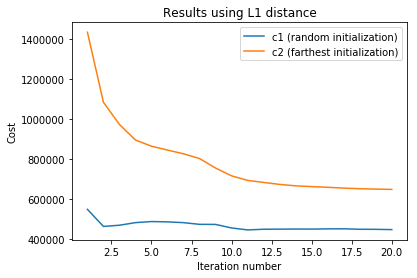

In [14]:
import matplotlib.pyplot as plt
x = np.arange(1,21)
plt.plot(x,loss11, label='c1 (random initialization)')
plt.plot(x,loss21, label='c2 (farthest initialization)')
plt.title('Results using L1 distance')
plt.xlabel('Iteration number')
plt.ylabel('Cost')
plt.legend()
plt.savefig('/content/gdrive/My Drive/BigData/q1/Q1_1.png')

## (2) 在data.txt上以c1.txt和c2.txt作为初始质心运行群集，并使用L2。计算并绘制每次迭代集群内部成本。您需要在此处提交两个图表。

In [0]:
data12, centroids12, loss12 = kmeans(data, centroids1, norm=2)
data22, centroids22, loss22 = kmeans(data, centroids2, norm=2)

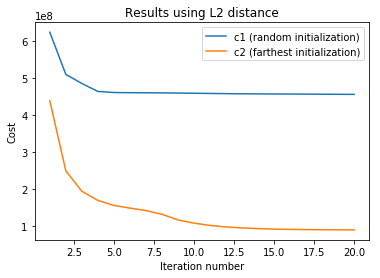

In [13]:
import matplotlib.pyplot as plt
x = np.arange(1,21)
plt.plot(x,loss12, label='c1 (random initialization)')
plt.plot(x,loss22, label='c2 (farthest initialization)')
plt.title('Results using L2 distance')
plt.xlabel('Iteration number')
plt.ylabel('Cost')
plt.legend()
plt.savefig('/content/gdrive/My Drive/BigData/q1/Q1_2.png')

## (3) T-SNE是一种降维方法，特别适合于可视化高维数据。可视化您的（2）的聚类分配结果，将尺寸缩小到2D空间。您需要在此处提交两个图表。

In [0]:
from sklearn.manifold import TSNE

In [50]:
data_np = np.array(data.collect())
data_np.shape

(4601, 58)

In [52]:
data_embedded = TSNE(n_components=2).fit_transform(data_np)
data_embedded.shape

(4601, 2)

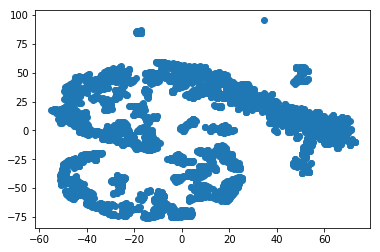

In [53]:
vis_x = data_embedded[:,0]
vis_y = data_embedded[:,1]
plt.scatter(vis_x, vis_y, cmap=plt.cm.get_cmap("jet",10))
plt.show()